In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geoplot as gplt
import geopandas as gpd

%matplotlib inline

/home/vagrant/miniconda3/envs/ipykernel_py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


3/1/17

In this notebook I test doing some basic rollups of demographic data from ACS census tables (2010-2015 averages) by fire management area. In addition, I attempt to explore the capabilities of the geopandas and geoplot libraries for easy python-based static spatial mapping within a notebook.

[GeoPandas](http://geopandas.org/) is a library that allows us to manipulate geospatial data in a geodataframe in Pandas. Leveraing the packages Shapely and Fiona, it allows for spatial operations, and also allows plotting of maps with matplotlib.

[geoplot](http://www.residentmar.io/geoplot/index.html) is a python library that extends cartopy and matplotlib for easy static visualizations of spatial data - like seaborn to matplotlib.

**NOTE: geopandas currently requires a python 3.5 environment and is not available for windows**


One way to do address this is use conda to create a python 3.5 enviroment for working with geopandas/geoplot which is the approach I took to create this notebook:

    conda create -n py35 python=3.5 ipykernel geoplot

3/6/17

Added scatterplots of median response time (dispatched to on-scene) vs various demographic metrics by FMA to look for any interesting patterns or correlations. The median response time values were acquired from analyses in @matthino's notebook.

4/27/17
Updated broken queries after datatype in fma_shapes and fmac_proportion was changed to INTEGER. 



In [2]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [3]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("erdatabase"), user=os.environ.get("eruser"), 
                            password = os.environ.get("erpassword"), 
                            host=os.environ.get("erhost"), port=os.environ.get("erport"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [4]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, executes query in psql, and pulls results into pandas df
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [5]:
'''
This function takes an SQL query, connects to postgres, 
and creates a geodataframe containing the spatial data
You use it like the pquery() function above, 
but call it when you want to incorporate a column with 
shape data into a dataframe
'''

from geopandas import GeoSeries, GeoDataFrame

def gpd_query(QUERY):
    '''
    takes SQL query string, connects to postgres, and creates geopandas dataframe
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY+'\r\n')
        geo_df = GeoDataFrame.from_postgis(QUERY, 
        conn, geom_col='geom', crs={'init': u'epsg:4326'}, 
        coerce_float=False)
        
        print("created geopandas dataframe!")
        return geo_df
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [6]:
# get all rows from census block to fma lookup table 
QUERY1='''SELECT *
FROM fmac_proportion;
'''

In [7]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = SELECT *
FROM fmac_proportion;



In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 4 columns):
c_block        770 non-null object
fma            770 non-null int64
overlap_cbg    770 non-null float64
overlap_fma    770 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 24.1+ KB


In [9]:
df1.head(10)

,c_block,fma,overlap_cbg,overlap_fma
0,410050201001,10,0.002468,7.874073e-04
1,410050203032,10,0.000015,7.926580e-07
2,410050203041,18,0.000056,4.442453e-06
3,410050208001,10,0.001001,2.550445e-04
4,410050208001,20,0.055454,1.285901e-02
5,410050209001,20,0.239613,8.783360e-03
6,410050210001,25,0.003061,1.808271e-04
7,410050210002,20,0.006363,6.558618e-04
8,410050210002,25,0.015021,1.445884e-03
9,410050212001,20,0.042128,4.428812e-03


Each row in this lookup table above is an intersection of census block group (c_block) to Fire Management Area (fma). Using a weighted average approach, we can join census block group data tables to this lookup table in order to create estimates of census block group-based data by fire management area. Some column descriptions:

* overlap_cbg is the proprtion calculated by intersection area / total census block area

* overlap_fma is the proportion calculated by intersection area / total fma area



**Below I test some queries converting data by census block group to fma and mapping this data using geoplot**

In [10]:
# load median response times by fma 
import csv

fma_med_response = pd.read_csv("../notebooks/responseTimeMetricsData/fma_med_resp_time.csv")
                               
# conform med_resp_time_overall column name to match rest of notebook
fma_med_response = fma_med_response.rename(columns = {'med_resp_time_overall':'median_response_time'})
fma_med_response

,fma,med_resp_time_med,med_resp_time_fire,median_response_time
0,1,4.05,4.32,4.10
1,2,5.02,4.93,5.15
2,3,4.27,4.32,4.35
3,4,4.00,4.58,4.20
4,5,5.27,5.02,5.42
5,6,4.97,5.13,5.20
6,7,4.40,4.22,4.50
7,8,3.73,4.31,3.97
8,9,4.38,4.27,4.47
9,10,5.62,5.32,5.82


In [11]:
# try joining census total population by census block group to fma
# include fma geometry in query

QUERY2='''SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total,
  round(sum(a.area*f.overlap_cbg)) AS fma_area_total,
  s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN (select geoid, aland + awater area FROM ceblocks) a
ON f.c_block = a.geoid
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC
'''

In [12]:
df2 = gpd_query(QUERY2) # note the use of gdp_query() since we want to return a geopandas dataframe

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total,
  round(sum(a.area*f.overlap_cbg)) AS fma_area_total,
  s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN (select geoid, aland + awater area FROM ceblocks) a
ON f.c_block = a.geoid
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC


created geopandas dataframe!


In [13]:
df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
fma                     31 non-null int64
fma_population_total    31 non-null int64
fma_area_total          31 non-null float64
geom                    31 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 1.0+ KB


In [14]:
df2['fma_population_density'] = df2['fma_population_total'] / df2['fma_area_total'] * 1000000

In [15]:
df2

,fma,fma_population_total,fma_area_total,geom,fma_population_density
0,7,42544,14774760.0,"(POLYGON ((-122.53768848 45.49444708800007, -1...",2879.505319
1,25,41133,12929802.0,(POLYGON ((-122.5996791489999 45.4614523220000...,3181.255212
2,14,37634,20764235.0,(POLYGON ((-122.6452597909999 45.5482393280000...,1812.443367
3,9,34321,8939766.0,"(POLYGON ((-122.618542734 45.49893638500004, -...",3839.138519
4,11,34236,13583959.0,(POLYGON ((-122.5648676069999 45.4598086640000...,2520.325628
5,31,31487,10932487.0,"(POLYGON ((-122.487770149 45.48629978200006, -...",2880.131483
6,19,30588,10847022.0,"(POLYGON ((-122.581914988 45.50345943100007, -...",2819.944497
7,28,28355,9894554.0,"(POLYGON ((-122.628283273 45.52984537400005, -...",2865.717848
8,18,27347,15683763.0,"(POLYGON ((-122.733431708 45.43437200000005, -...",1743.650424
9,29,24628,16255707.0,"(POLYGON ((-122.532502628 45.46131735600005, -...",1515.037150


In [16]:
QUERY2A = '''
select 
    fmarespcomp fma,
    sum(case when isfc.incsitfoundclass_id in (1, 2) then 1 else 0 end) fire_incidents,
    sum(case when isfc.incsitfoundclass_id = 3 then 1 else 0 end) medical_incidents,
    count(1) total_incidents
from incident as inc
join incsitfound as isf
    on inc.incsitfoundprm_id = isf.incsitfound_id
join incsitfoundsub as isfs
    on isf.incsitfoundsub_id = isfs.incsitfoundsub_id
join incsitfoundclass as isfc
    on isfs.incsitfoundclass_id = isfc.incsitfoundclass_id
where date_part('year', inc.incdate) = 2016
group by 1;
'''

In [17]:
df2a = pquery(QUERY2A)

Opened database successfully
SQL QUERY = 
select 
    fmarespcomp fma,
    sum(case when isfc.incsitfoundclass_id in (1, 2) then 1 else 0 end) fire_incidents,
    sum(case when isfc.incsitfoundclass_id = 3 then 1 else 0 end) medical_incidents,
    count(1) total_incidents
from incident as inc
join incsitfound as isf
    on inc.incsitfoundprm_id = isf.incsitfound_id
join incsitfoundsub as isfs
    on isf.incsitfoundsub_id = isfs.incsitfoundsub_id
join incsitfoundclass as isfc
    on isfs.incsitfoundclass_id = isfc.incsitfoundclass_id
where date_part('year', inc.incdate) = 2016
group by 1;



In [18]:
df2a

,fma,fire_incidents,medical_incidents,total_incidents
0,18,59,1499,2064
1,None,37,403,784
2,02,65,1537,2112
3,17,64,870,1354
4,OF,15,96,240
5,03,150,3278,4946
6,25,88,2390,3337
7,07,185,5443,7019
8,11,163,3532,4818
9,12,88,1795,2564


In [19]:
# need to convert df2a fma datatype
df2a['fma']= pd.to_numeric(df2a['fma'],errors='coerce')
df2a = df2a.dropna()
df2a['fma'] = df2a['fma'].astype(int) 
df2a

/home/vagrant/miniconda3/envs/ipykernel_py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,fma,fire_incidents,medical_incidents,total_incidents
0,18,59,1499,2064
2,2,65,1537,2112
3,17,64,870,1354
5,3,150,3278,4946
6,25,88,2390,3337
7,7,185,5443,7019
8,11,163,3532,4818
9,12,88,1795,2564
10,10,18,359,596
11,89,0,2,74


In [20]:
df2 = pd.merge(df2, df2a, how = 'left', on= 'fma')
df2['fire_incidents_per_1000'] = df2['fire_incidents'] / df2['fma_population_total'] * 1000
df2['medical_incidents_per_1000'] = df2['medical_incidents'] / df2['fma_population_total'] * 1000
df2['total_incidents_per_1000'] = df2['total_incidents'] / df2['fma_population_total'] * 1000
df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 11 columns):
fma                           31 non-null int64
fma_population_total          31 non-null int64
fma_area_total                31 non-null float64
geom                          31 non-null object
fma_population_density        31 non-null float64
fire_incidents                31 non-null int64
medical_incidents             31 non-null int64
total_incidents               31 non-null int64
fire_incidents_per_1000       31 non-null float64
medical_incidents_per_1000    31 non-null float64
total_incidents_per_1000      31 non-null float64
dtypes: float64(5), int64(5), object(1)
memory usage: 2.9+ KB


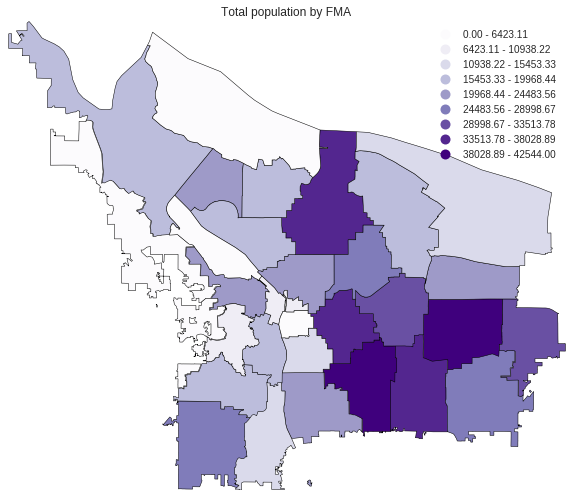

In [21]:
# map of population by fma
import geoplot.crs as gcrs # allow different projections

gplt.choropleth(df2,
                hue=df2['fma_population_total'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Purples',
                linewidth=0.5,
                edgecolor='black',
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total population by FMA")

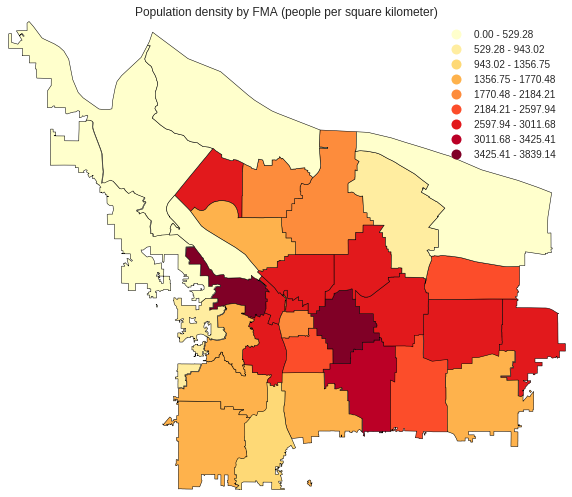

In [22]:
# map of population depsity by fma

gplt.choropleth(df2,
                hue=df2['fma_population_density'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlOrRd',
                linewidth=0.5,
                edgecolor='black',
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("Population density by FMA (people per square kilometer)")

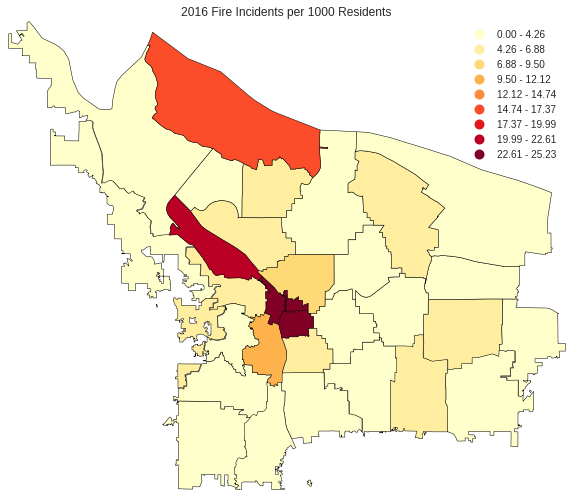

In [23]:
gplt.choropleth(df2,
                hue=df2['fire_incidents_per_1000'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlOrRd',
                linewidth=0.5,
                edgecolor='black',
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("2016 Fire Incidents per 1000 Residents")

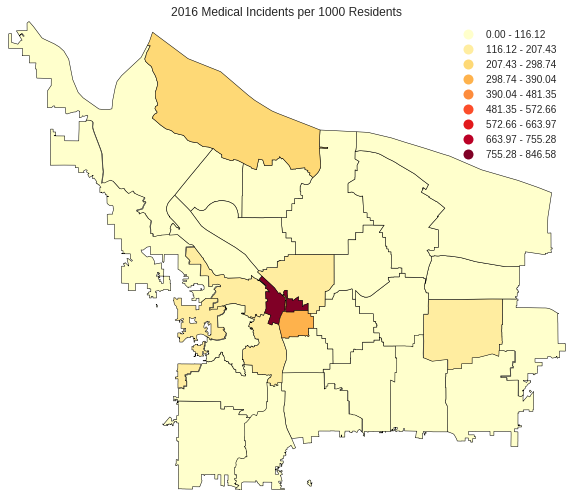

In [24]:
gplt.choropleth(df2,
                hue=df2['medical_incidents_per_1000'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlOrRd',
                linewidth=0.5,
                edgecolor='black',
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("2016 Medical Incidents per 1000 Residents")

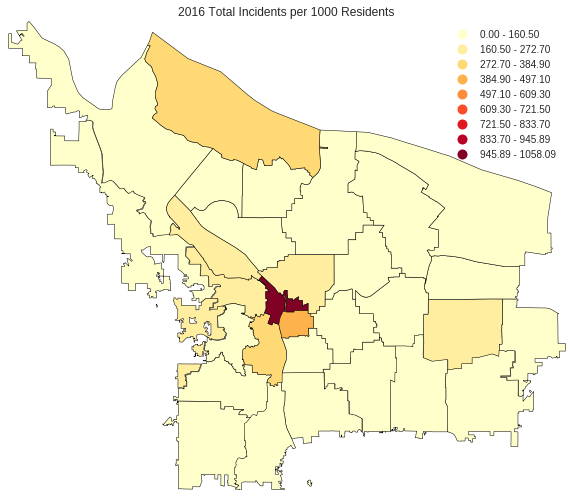

In [25]:
gplt.choropleth(df2,
                hue=df2['total_incidents_per_1000'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlOrRd',
                linewidth=0.5,
                edgecolor='black',
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("2016 Total Incidents per 1000 Residents")

In [26]:
# look at datatypes of fma_med_response df
fma_med_response.info() 

# since df2.fma datatype is object, we convert it to an integer before attempting to merge with fma_med_response
# otherwise merge will return empty table
#df2.fma = df2.fma.astype(int)


#merge (join) the dataframes on 'fma', print it out for inspection
merged = fma_med_response.merge(df2, on='fma')

merged[merged.columns[:-1]] #print merged df but omit the polygon column 
merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
fma                     31 non-null int64
med_resp_time_med       31 non-null float64
med_resp_time_fire      31 non-null float64
median_response_time    31 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1.0 KB


,fma,med_resp_time_med,med_resp_time_fire,median_response_time,fma_population_total,fma_area_total,geom,fma_population_density,fire_incidents,medical_incidents,total_incidents,fire_incidents_per_1000,medical_incidents_per_1000,total_incidents_per_1000
0,1,4.05,4.32,4.10,7333,2653197.0,"(POLYGON ((-122.654647701 45.52077605700003, -...",2763.835478,185,6208,7759,25.228419,846.583936,1058.093550
1,2,5.02,4.93,5.15,15268,36946864.0,"(POLYGON ((-122.55780558 45.55178617400003, -1...",413.242109,65,1537,2112,4.257270,100.668064,138.328530
2,3,4.27,4.32,4.35,22086,6330477.0,"(POLYGON ((-122.687297627 45.51911160700007, -...",3488.836623,150,3278,4946,6.791633,148.419813,223.942769
3,4,4.00,4.58,4.20,17533,6132110.0,"(POLYGON ((-122.667871984 45.49139775000003, -...",2859.211593,182,3319,4894,10.380425,189.300177,279.130782
4,5,5.27,5.02,5.42,17793,10436207.0,"(POLYGON ((-122.744500398 45.47635703600008, -...",1704.929770,32,819,1216,1.798460,46.029337,68.341483
5,6,4.97,5.13,5.20,1908,8536973.0,"(POLYGON ((-122.685554985 45.54041087700006, -...",223.498423,41,162,388,21.488470,84.905660,203.354298
6,7,4.40,4.22,4.50,42544,14774760.0,"(POLYGON ((-122.53768848 45.49444708800007, -1...",2879.505319,185,5443,7019,4.348439,127.938135,164.982136
7,8,3.73,4.31,3.97,17209,9512724.0,"(POLYGON ((-122.659356838 45.57443762700007, -...",1809.050699,94,1462,2064,5.462258,84.955547,119.937242
8,9,4.38,4.27,4.47,34321,8939766.0,"(POLYGON ((-122.618542734 45.49893638500004, -...",3839.138519,96,1865,2660,2.797121,54.339909,77.503569
9,10,5.62,5.32,5.82,10972,11009096.0,"(POLYGON ((-122.669351416 45.43576608800004, -...",996.630423,18,359,596,1.640540,32.719650,54.320087


In [27]:
cleaned = merged.drop(merged.index[[26]])
cleaned[['median_response_time','fma_population_total']].corr()

,median_response_time,fma_population_total
median_response_time,1.000000,-0.379201
fma_population_total,-0.379201,1.000000


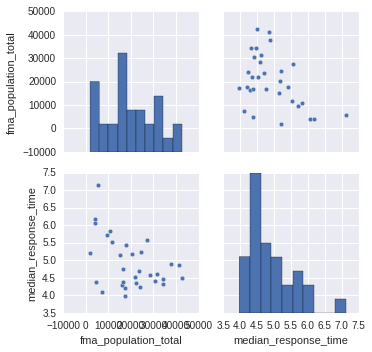

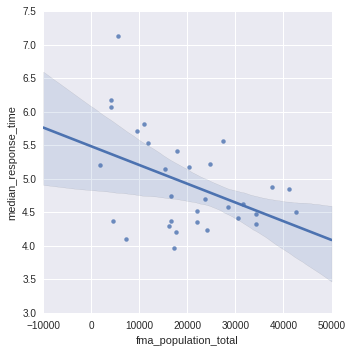

In [28]:
sns.pairplot(merged, vars = ['fma_population_total','median_response_time'])
sns.lmplot('fma_population_total', 'median_response_time',
           data=merged,
           fit_reg=True)

In [29]:
# save to csv for import to db
merged.pop('geom')
merged.to_csv("responseTimeMetricsData/incidents_per1000_fma.csv", index=False)

In [30]:
# explore household tenure (owner-occupied vs renter occupied) by FMA

QUERY3='''SELECT f.fma,
  CAST(round(sum(c.estimate_total_households*f.overlap_cbg)) AS INTEGER) AS total_households,
  CAST(round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS INTEGER) AS total_owner_occupied,
  (sum(c.estimate_total_owner_occupied*f.overlap_cbg))/(sum(c.estimate_total_households*f.overlap_cbg))
  AS percent_owner_occupied,
  CAST(round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS INTEGER) AS total_renter_occupied,
  (sum(c.estimate_total_renter_occupied*f.overlap_cbg)/sum(c.estimate_total_households*f.overlap_cbg))
    AS percent_renter_occupied,
  s.geom
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY total_households DESC
'''

In [31]:
df3 = gpd_query(QUERY3)  

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total_households*f.overlap_cbg)) AS INTEGER) AS total_households,
  CAST(round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS INTEGER) AS total_owner_occupied,
  (sum(c.estimate_total_owner_occupied*f.overlap_cbg))/(sum(c.estimate_total_households*f.overlap_cbg))
  AS percent_owner_occupied,
  CAST(round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS INTEGER) AS total_renter_occupied,
  (sum(c.estimate_total_renter_occupied*f.overlap_cbg)/sum(c.estimate_total_households*f.overlap_cbg))
    AS percent_renter_occupied,
  s.geom
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY total_households DESC


created geopandas dataframe!


In [32]:
df3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
fma                        31 non-null int64
total_households           31 non-null int64
total_owner_occupied       31 non-null int64
percent_owner_occupied     31 non-null float64
total_renter_occupied      31 non-null int64
percent_renter_occupied    31 non-null float64
geom                       31 non-null object
dtypes: float64(2), int64(4), object(1)
memory usage: 1.8+ KB


In [33]:
df3[df3.columns[:5]] # not printing out geom column which is in last column

,fma,total_households,total_owner_occupied,percent_owner_occupied,total_renter_occupied
0,25,17263,9648,0.558886,7615
1,9,15456,8071,0.522185,7385
2,7,14879,6141,0.412705,8738
3,14,14326,9551,0.666703,4775
4,3,14052,3640,0.259041,10412
5,19,12574,6989,0.555833,5585
6,11,12245,6399,0.522552,5847
7,28,11831,7678,0.648990,4153
8,18,11570,7581,0.655211,3989
9,13,11457,4717,0.411670,6741


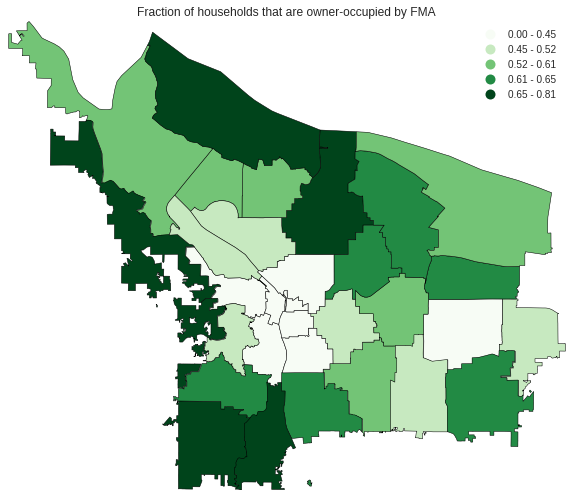

In [34]:
gplt.choropleth(df3,
                hue=df3['percent_owner_occupied'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Greens',
                linewidth=0.5,
                #k=9,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households that are owner-occupied by FMA")

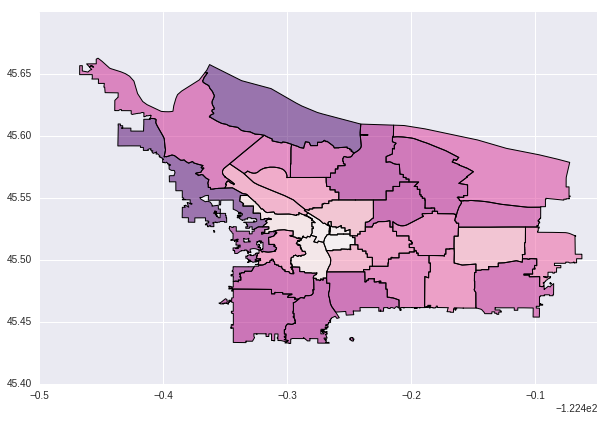

In [35]:
# just for visual comparison, here is the same choropleth map 
# of FMA by percent owner occupied using matplotlib
# NOTE: I had to remove the legend to prevent matplotlib from 
# throwing an error from scaling based on a float number

df3.plot(column='percent_owner_occupied', cmap= 'RdPu',figsize=(10,10))

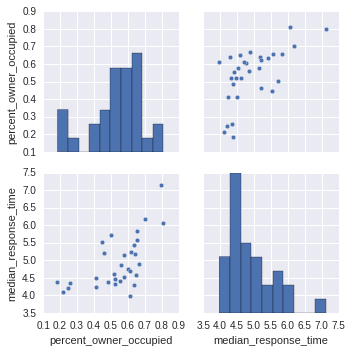

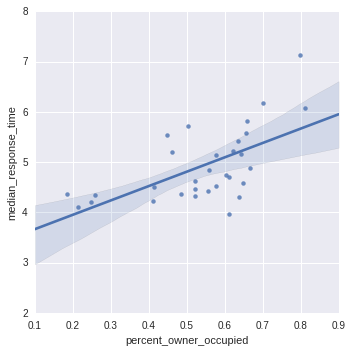

In [36]:
# generate pairplot/scatterplot of percent owner occupied and response time

df3.fma = df3.fma.astype(int)
merged = fma_med_response.merge(df3, on='fma')
sns.pairplot(merged, vars = ['percent_owner_occupied','median_response_time'])
sns.lmplot('percent_owner_occupied', 'median_response_time',
           data=merged,
           fit_reg=True)

In [37]:
cleaned = merged.drop(merged.index[[26]])
#cleaned[['median_response_time','fma_population_total']].corr()
cleaned.corr()

,fma,med_resp_time_med,med_resp_time_fire,median_response_time,total_households,total_owner_occupied,percent_owner_occupied,total_renter_occupied,percent_renter_occupied
fma,1.000000,0.130383,0.026018,0.110491,0.048183,0.264414,0.334671,-0.182430,-0.334671
med_resp_time_med,0.130383,1.000000,0.830056,0.994107,-0.415831,-0.194541,0.541232,-0.533397,-0.541232
med_resp_time_fire,0.026018,0.830056,1.000000,0.860206,-0.600742,-0.421487,0.390735,-0.628722,-0.390735
median_response_time,0.110491,0.994107,0.860206,1.000000,-0.436911,-0.206650,0.556424,-0.558167,-0.556424
total_households,0.048183,-0.415831,-0.600742,-0.436911,1.000000,0.874560,-0.063377,0.871884,0.063377
total_owner_occupied,0.264414,-0.194541,-0.421487,-0.206650,0.874560,1.000000,0.347446,0.525044,-0.347446
percent_owner_occupied,0.334671,0.541232,0.390735,0.556424,-0.063377,0.347446,1.000000,-0.462117,-1.000000
total_renter_occupied,-0.182430,-0.533397,-0.628722,-0.558167,0.871884,0.525044,-0.462117,1.000000,0.462117
percent_renter_occupied,-0.334671,-0.541232,-0.390735,-0.556424,0.063377,-0.347446,-1.000000,0.462117,1.000000


In [38]:
# try joining census estimate_median_household_income by census block group to fma
# note this is not a statistically valid query since we can't simply apply a weighted average to medians
# but it's at least one approach to approximate a median for fmas

QUERY4='''SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income,
  s.geom
FROM fmac_proportion f 
  INNER JOIN census_median_household_income c
  ON f.c_block = c.id2
  INNER JOIN fma_shapes s
  ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY median_household_income DESC
'''

In [39]:
df4 = gpd_query(QUERY4)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income,
  s.geom
FROM fmac_proportion f 
  INNER JOIN census_median_household_income c
  ON f.c_block = c.id2
  INNER JOIN fma_shapes s
  ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY median_household_income DESC


created geopandas dataframe!


In [40]:
#df4.info()

In [41]:
df4[df4.columns[:2]]

,fma,median_household_income
0,27,137883.0
1,16,130537.0
2,15,117597.0
3,10,108234.0
4,5,90861.0
5,3,90696.0
6,6,84673.0
7,18,81527.0
8,22,72752.0
9,9,71971.0


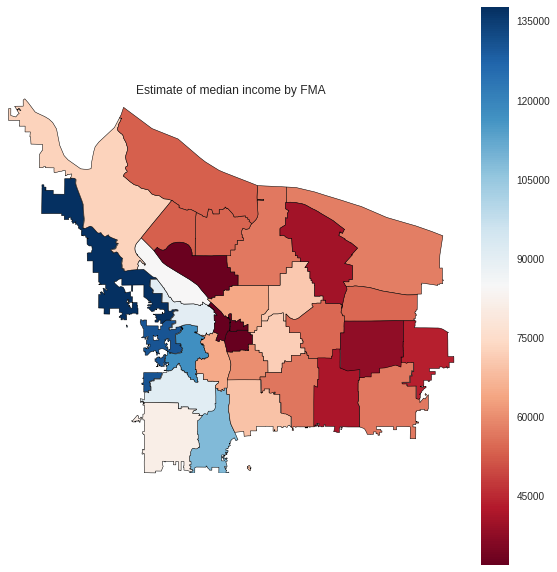

In [42]:
gplt.choropleth(df4,
                hue=df4['median_household_income'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='RdBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Estimate of median income by FMA")

In the choropleth map above, I chose to use a diverging colormap to better highlight differences in the estimate of median income by FMA.One can see that the FMAs to the West side of te Williamette River tend to have higher estimated household median income. The lowest estimate FMAs occur in central close-in Eastside and then closer to the Eastern edge of PF&R's territory. 

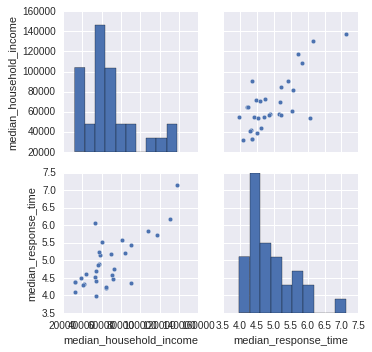

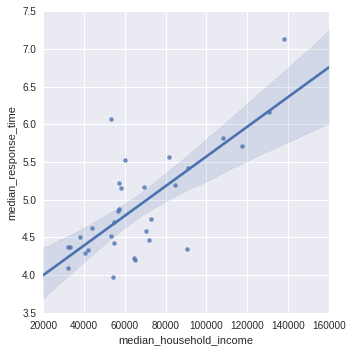

In [43]:
# generate pairplot/scatterplot of median_household_income and response time

df4.fma = df4.fma.astype(int)
merged = fma_med_response.merge(df4, on='fma')
sns.pairplot(merged, vars = ['median_household_income','median_response_time'])
sns.lmplot('median_household_income', 'median_response_time',
           data=merged,
           fit_reg=True)

In [44]:
cleaned = merged.drop(merged.index[[26]])
cleaned.corr()

,fma,med_resp_time_med,med_resp_time_fire,median_response_time,median_household_income
fma,1.000000,0.130383,0.026018,0.110491,-0.174720
med_resp_time_med,0.130383,1.000000,0.830056,0.994107,0.645826
med_resp_time_fire,0.026018,0.830056,1.000000,0.860206,0.481529
median_response_time,0.110491,0.994107,0.860206,1.000000,0.653028
median_household_income,-0.174720,0.645826,0.481529,0.653028,1.000000


In [45]:
# explore health insurance status by FMA
QUERY5='''SELECT f.fma,
  round(sum(c.with_health_insurance*f.overlap_cbg)) AS with_health_insurance,
  ((sum(c.with_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_with_health_insurance,
  round(sum(c.no_health_insurance*f.overlap_cbg)) AS no_health_insurance,
  ((sum(c.no_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_no_health_insurance,
  s.geom    
FROM fmac_proportion f INNER JOIN census_health_insurance c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_no_health_insurance DESC
'''

In [46]:
df5 = gpd_query(QUERY5)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.with_health_insurance*f.overlap_cbg)) AS with_health_insurance,
  ((sum(c.with_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_with_health_insurance,
  round(sum(c.no_health_insurance*f.overlap_cbg)) AS no_health_insurance,
  ((sum(c.no_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_no_health_insurance,
  s.geom    
FROM fmac_proportion f INNER JOIN census_health_insurance c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_no_health_insurance DESC


created geopandas dataframe!


In [47]:
df5[df5.columns[:5]]

,fma,with_health_insurance,percent_with_health_insurance,no_health_insurance,percent_no_health_insurance
0,21,3998.0,0.871431,590.0,0.128569
1,7,37635.0,0.892322,4541.0,0.107678
2,23,10479.0,0.892609,1261.0,0.107391
3,29,21756.0,0.894004,2580.0,0.105996
4,31,28044.0,0.896326,3244.0,0.103674
5,24,15024.0,0.901578,1640.0,0.098422
6,1,6228.0,0.904346,659.0,0.095654
7,26,19837.0,0.905223,2077.0,0.094777
8,11,30818.0,0.905835,3204.0,0.094165
9,25,37155.0,0.907645,3781.0,0.092355


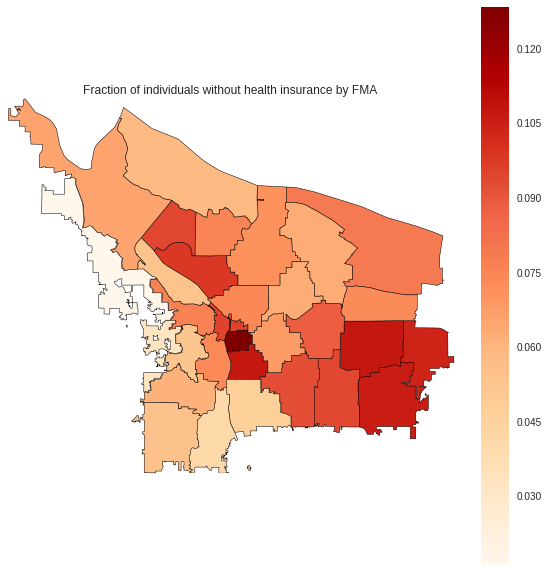

In [48]:
gplt.choropleth(df5,
                hue=df5['percent_no_health_insurance'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of individuals without health insurance by FMA")

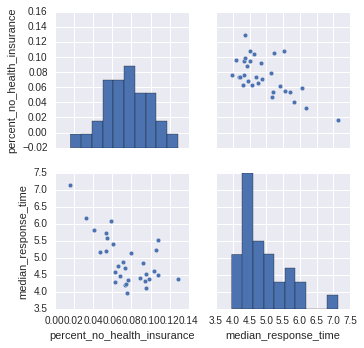

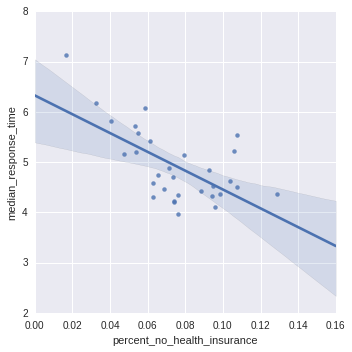

In [49]:
# generate pairplot/scatterplot of percent_no_health_insurance and response time

df5.fma = df5.fma.astype(int)
merged = fma_med_response.merge(df5, on='fma')
sns.pairplot(merged, vars = ['percent_no_health_insurance','median_response_time'])
sns.lmplot('percent_no_health_insurance', 'median_response_time',
           data=merged,
           fit_reg=True)

In [50]:
cleaned = merged.drop(merged.index[[26]])
cleaned.corr()

,fma,med_resp_time_med,med_resp_time_fire,median_response_time,with_health_insurance,percent_with_health_insurance,no_health_insurance,percent_no_health_insurance
fma,1.000000,0.130383,0.026018,0.110491,0.200985,-0.248184,0.239375,0.248184
med_resp_time_med,0.130383,1.000000,0.830056,0.994107,-0.346456,0.496950,-0.382985,-0.496950
med_resp_time_fire,0.026018,0.830056,1.000000,0.860206,-0.574884,0.451731,-0.599044,-0.451731
median_response_time,0.110491,0.994107,0.860206,1.000000,-0.369190,0.526492,-0.413310,-0.526492
with_health_insurance,0.200985,-0.346456,-0.574884,-0.369190,1.000000,-0.251596,0.915118,0.251596
percent_with_health_insurance,-0.248184,0.496950,0.451731,0.526492,-0.251596,1.000000,-0.534081,-1.000000
no_health_insurance,0.239375,-0.382985,-0.599044,-0.413310,0.915118,-0.534081,1.000000,0.534081
percent_no_health_insurance,0.248184,-0.496950,-0.451731,-0.526492,0.251596,-1.000000,0.534081,1.000000


In [51]:
# explore educational attainment by FMA
# aggregate by calculating % of individuals with just college degree, % with college degree or higher

QUERY6= '''SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.bachelor_degree*f.overlap_cbg)) AS college_grad,
  ((sum(c.bachelor_degree*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_college_grad,
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))) AS college_grad_or_higher,   
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))
  /(sum(c.total*f.overlap_cbg))) AS percent_college_grad_or_higher,
  s.geom   
FROM fmac_proportion f INNER JOIN census_educational_attainment c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_college_grad_or_higher DESC
'''



In [52]:
df6 = gpd_query(QUERY6)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.bachelor_degree*f.overlap_cbg)) AS college_grad,
  ((sum(c.bachelor_degree*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_college_grad,
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))) AS college_grad_or_higher,   
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))
  /(sum(c.total*f.overlap_cbg))) AS percent_college_grad_or_higher,
  s.geom   
FROM fmac_proportion f INNER JOIN census_educational_attainment c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_college_grad_or_higher DESC


created geopandas dataframe!


In [53]:
df6[df6.columns[0:6]] 

,fma,total,college_grad,percent_college_grad,college_grad_or_higher,percent_college_grad_or_higher
0,27,3807.0,1477.0,0.388002,2856.913706,0.750341
1,15,7032.0,2399.0,0.341100,5110.201464,0.726724
2,16,2995.0,1024.0,0.341891,2147.014002,0.716751
3,3,19089.0,7699.0,0.403344,13611.320333,0.713053
4,10,7798.0,2936.0,0.376440,5442.791215,0.697954
5,5,12927.0,4404.0,0.340710,8671.975085,0.670859
6,4,12800.0,4517.0,0.352925,8396.738025,0.655990
7,9,26581.0,9890.0,0.372060,17082.269334,0.642642
8,13,19132.0,6785.0,0.354660,12075.981566,0.631189
9,6,1398.0,450.0,0.322149,844.389567,0.603891


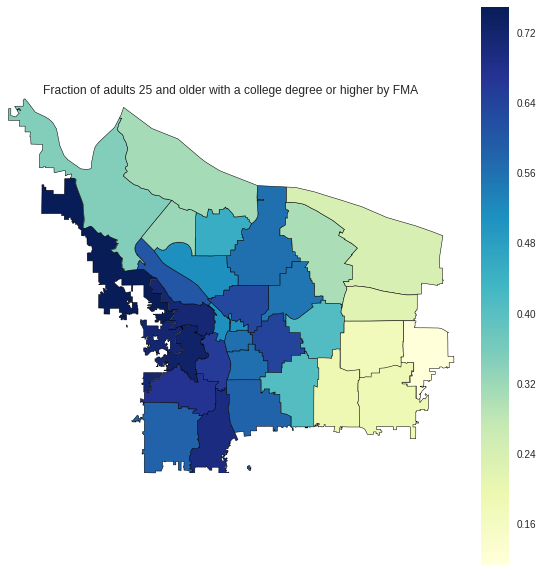

In [54]:
gplt.choropleth(df6,
                hue=df6['percent_college_grad_or_higher'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlGnBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of adults 25 and older with a college degree or higher by FMA")

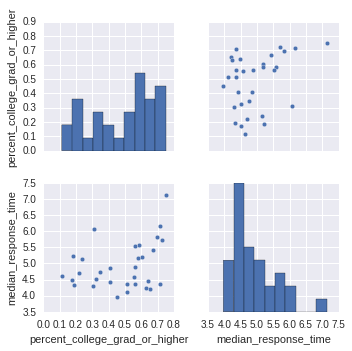

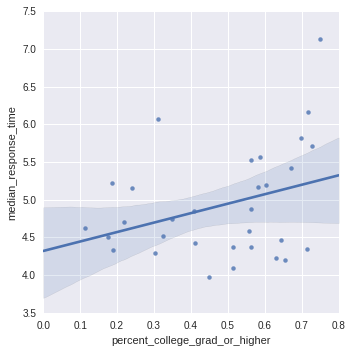

In [55]:
# generate pairplot/scatterplot of percent_college_grad_or_higher and response time

df6.fma = df6.fma.astype(int)
merged = fma_med_response.merge(df6, on='fma')
sns.pairplot(merged, vars = ['percent_college_grad_or_higher','median_response_time'])
sns.lmplot('percent_college_grad_or_higher', 'median_response_time',
           data=merged,
           fit_reg=True)

In [56]:
# explore food stamps by FMA
QUERY7 = '''SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.hh_rec_fs*f.overlap_cbg)) AS rec_food_stamps,
  ((sum(c.hh_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_rec_fs,
  round(sum(c.hh_dn_rec_fs*f.overlap_cbg)) AS dn_red_food_stamps,
  ((sum(c.hh_dn_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_dn_rec_fs,
  s.geom   
FROM fmac_proportion f INNER JOIN census_food_stamps c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY rec_food_stamps DESC
'''


In [57]:
df7 = gpd_query(QUERY7)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.hh_rec_fs*f.overlap_cbg)) AS rec_food_stamps,
  ((sum(c.hh_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_rec_fs,
  round(sum(c.hh_dn_rec_fs*f.overlap_cbg)) AS dn_red_food_stamps,
  ((sum(c.hh_dn_rec_fs*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_dn_rec_fs,
  s.geom   
FROM fmac_proportion f INNER JOIN census_food_stamps c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY rec_food_stamps DESC


created geopandas dataframe!


In [58]:
df7[df7.columns[:5]]

,fma,total,rec_food_stamps,percent_rec_fs,dn_red_food_stamps
0,7,14879.0,5227.0,0.351334,9651.0
1,11,12245.0,4077.0,0.332946,8168.0
2,31,10189.0,3620.0,0.355314,6569.0
3,25,17263.0,3421.0,0.198168,13842.0
4,19,12574.0,2596.0,0.206478,9978.0
5,14,14326.0,2370.0,0.165424,11957.0
6,3,14052.0,2219.0,0.157923,11833.0
7,29,7960.0,2149.0,0.269995,5811.0
8,4,10015.0,1865.0,0.186252,8150.0
9,9,15456.0,1832.0,0.118504,13625.0


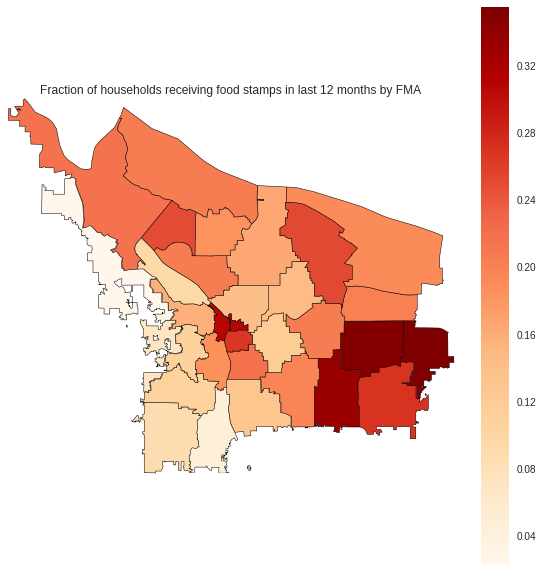

In [59]:
gplt.choropleth(df7,
                hue=df7['percent_rec_fs'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households receiving food stamps in last 12 months by FMA")

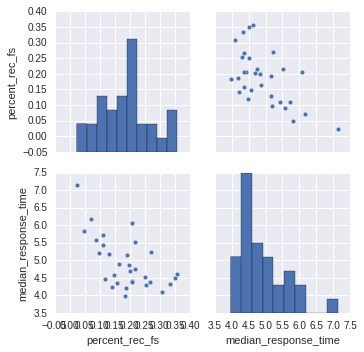

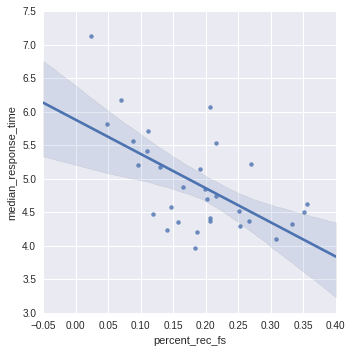

In [60]:
# generate pairplot/scatterplot of precent receiving food stamps and response time

df7.fma = df7.fma.astype(int)
merged = fma_med_response.merge(df7, on='fma')
sns.pairplot(merged, vars = ['percent_rec_fs','median_response_time'])
sns.lmplot('percent_rec_fs', 'median_response_time',
           data=merged,
           fit_reg=True)

In [61]:
# explore household language by FMA
# I chose to aggregate by housholds that speak English only
# and also limited english speaking status households (lesh)

QUERY8='''SELECT f.fma,
  round(sum(c.estimate_total*f.overlap_cbg)) AS total,
  round(sum(c.english_only*f.overlap_cbg)) AS english_only,
  ((sum(c.english_only*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_english_only,
  (round((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))) AS total_lesh,
  (((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))/
  (sum(c.estimate_total*f.overlap_cbg))) AS percent_total_lesh,
  s.geom    
FROM fmac_proportion f INNER JOIN census_household_language c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_total_lesh DESC
'''



In [62]:
df8 = gpd_query(QUERY8)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_total*f.overlap_cbg)) AS total,
  round(sum(c.english_only*f.overlap_cbg)) AS english_only,
  ((sum(c.english_only*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_english_only,
  (round((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))) AS total_lesh,
  (((sum(c.spanish_lesh*f.overlap_cbg)) + (sum(c.Other_Indo_Euro_lesh*f.overlap_cbg)) + 
  (sum(c.Asian_Pacific_Island_lesh*f.overlap_cbg)) + (sum(c.other_lesh*f.overlap_cbg)))/
  (sum(c.estimate_total*f.overlap_cbg))) AS percent_total_lesh,
  s.geom    
FROM fmac_proportion f INNER JOIN census_household_language c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_total_lesh DESC


created geopandas dataframe!


In [63]:
df8[df8.columns[:6]]

,fma,total,english_only,percent_english_only,total_lesh,percent_total_lesh
0,7,14879.0,10056.0,0.675863,1797.0,0.120807
1,31,10189.0,6841.0,0.671418,1127.0,0.110622
2,11,12245.0,8277.0,0.675937,1303.0,0.106402
3,29,7960.0,5512.0,0.692388,722.0,0.090656
4,2,5894.0,4366.0,0.740741,469.0,0.079562
5,12,6274.0,4806.0,0.766100,381.0,0.060692
6,4,10015.0,7775.0,0.776391,570.0,0.056941
7,30,8969.0,7189.0,0.801552,495.0,0.055228
8,19,12574.0,10495.0,0.834642,603.0,0.047934
9,26,7094.0,5487.0,0.773484,283.0,0.039835


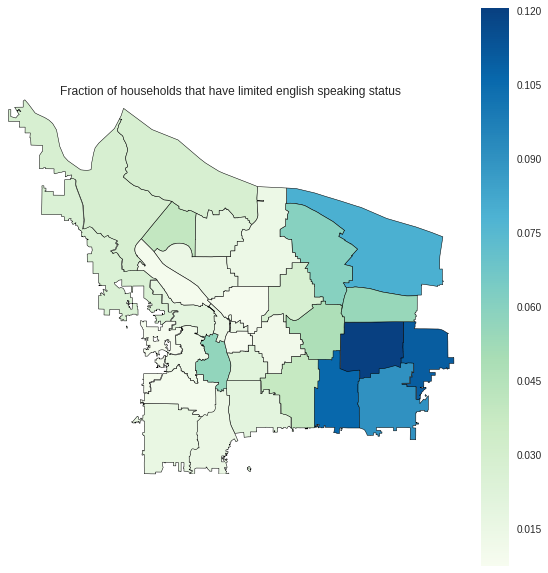

In [64]:
gplt.choropleth(df8,
                hue=df8['percent_total_lesh'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='GnBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households that have limited english speaking status")

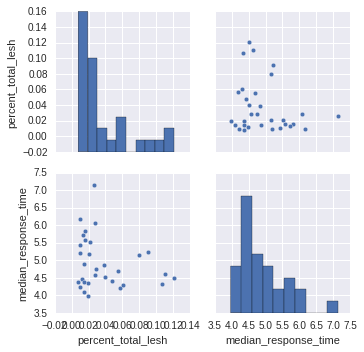

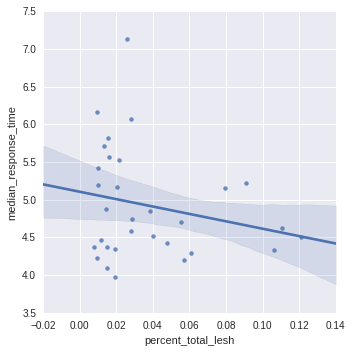

In [65]:
# generate pairplot/scatterplot of percent lesh and response time

df8.fma = df8.fma.astype(int)
merged = fma_med_response.merge(df8, on='fma')
sns.pairplot(merged, vars = ['percent_total_lesh','median_response_time'])
sns.lmplot('percent_total_lesh', 'median_response_time',
           data=merged,
           fit_reg=True)

In [66]:
# explore race by FMA 
# I chose to summarize by all race groups in the db table, but show on map as fraction of non-white

QUERY9='''SELECT f.fma, 
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.White_alone*f.overlap_cbg)) AS white_alone,
  round(sum(c.Black_alone*f.overlap_cbg)) AS black_alone,
  round(sum(c.American_Indian_Alaska_Native_alone*f.overlap_cbg)) AS natam_alkn_alone,
  round(sum(c.Asian_alone*f.overlap_cbg)) AS asian_alone,
  round(sum(c.Native_Hawaiian_Pacific_Islander_alone*f.overlap_cbg)) AS haw_pacis_alone,
  round(sum(c.Some_other_alone*f.overlap_cbg)) AS other_alone,
  round(sum(c.Two_or_more_races*f.overlap_cbg)) AS two_or_more,
  (((sum(c.total*f.overlap_cbg)) - (sum(c.White_alone*f.overlap_cbg)))/((sum(c.total*f.overlap_cbg)))) 
      AS percent_non_white,
  s.geom   
FROM fmac_proportion f INNER JOIN census_race c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_non_white DESC
'''


In [67]:
df9 = gpd_query(QUERY9)

Opened database successfully
SQL QUERY = SELECT f.fma, 
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.White_alone*f.overlap_cbg)) AS white_alone,
  round(sum(c.Black_alone*f.overlap_cbg)) AS black_alone,
  round(sum(c.American_Indian_Alaska_Native_alone*f.overlap_cbg)) AS natam_alkn_alone,
  round(sum(c.Asian_alone*f.overlap_cbg)) AS asian_alone,
  round(sum(c.Native_Hawaiian_Pacific_Islander_alone*f.overlap_cbg)) AS haw_pacis_alone,
  round(sum(c.Some_other_alone*f.overlap_cbg)) AS other_alone,
  round(sum(c.Two_or_more_races*f.overlap_cbg)) AS two_or_more,
  (((sum(c.total*f.overlap_cbg)) - (sum(c.White_alone*f.overlap_cbg)))/((sum(c.total*f.overlap_cbg)))) 
      AS percent_non_white,
  s.geom   
FROM fmac_proportion f INNER JOIN census_race c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_non_white DESC


created geopandas dataframe!


In [68]:
df9[df9.columns[:-1]]

,fma,total,white_alone,black_alone,natam_alkn_alone,asian_alone,haw_pacis_alone,other_alone,two_or_more,percent_non_white
0,2,15268.0,9792.0,2036.0,73.0,1627.0,168.0,409.0,1163.0,0.358650
1,7,42544.0,27794.0,2884.0,552.0,5684.0,583.0,2712.0,2335.0,0.346702
2,31,31487.0,21635.0,2140.0,297.0,2724.0,472.0,2887.0,1334.0,0.312903
3,11,34236.0,23686.0,1702.0,270.0,5738.0,72.0,1270.0,1497.0,0.308156
4,12,16281.0,11306.0,1552.0,128.0,1544.0,88.0,978.0,684.0,0.305583
5,26,21932.0,15281.0,3269.0,222.0,1063.0,456.0,214.0,1426.0,0.303252
6,29,24628.0,17587.0,1281.0,154.0,2900.0,235.0,1624.0,848.0,0.285904
7,30,23736.0,17036.0,1627.0,205.0,1882.0,317.0,1426.0,1244.0,0.282279
8,24,16678.0,11972.0,2745.0,32.0,627.0,12.0,424.0,866.0,0.282172
9,14,37634.0,27493.0,5639.0,258.0,1098.0,32.0,650.0,2464.0,0.269480


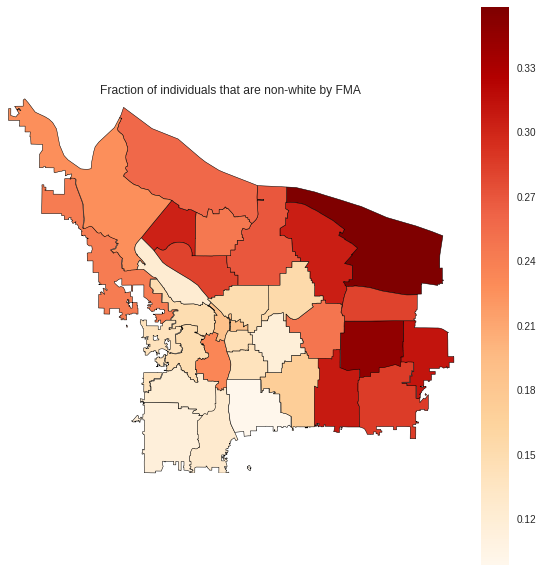

In [69]:
gplt.choropleth(df9,
                hue=df9['percent_non_white'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of individuals that are non-white by FMA")

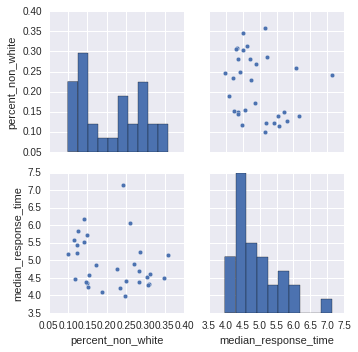

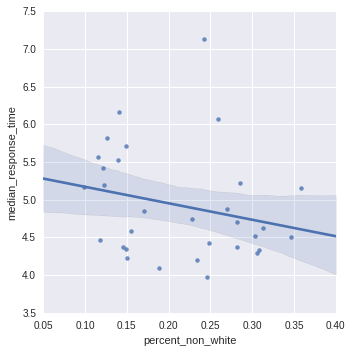

In [70]:
# generate pairplot/scatterplot of fraction non-white and response time

df9.fma = df9.fma.astype(int)
merged = fma_med_response.merge(df9, on='fma')
sns.pairplot(merged, vars = ['percent_non_white','median_response_time'])
sns.lmplot('percent_non_white', 'median_response_time',
           data=merged,
           fit_reg=True)

In [71]:
# explore poverty status by FMA

QUERY10='''SELECT f.fma, 
  round(sum(c.estimate_total*f.overlap_cbg)) AS total,
  round(sum(c.total_below*f.overlap_cbg)) AS below_pov_line,
  ((sum(c.total_below*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_below_pov,
  round(sum(c.total_above*f.overlap_cbg)) AS above_pov_line,
  ((sum(c.total_above*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_above_pov,
  s.geom   
FROM fmac_proportion f INNER JOIN census_poverty_status_individuals c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_below_pov DESC
'''

In [72]:
df10 = gpd_query(QUERY10)

Opened database successfully
SQL QUERY = SELECT f.fma, 
  round(sum(c.estimate_total*f.overlap_cbg)) AS total,
  round(sum(c.total_below*f.overlap_cbg)) AS below_pov_line,
  ((sum(c.total_below*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_below_pov,
  round(sum(c.total_above*f.overlap_cbg)) AS above_pov_line,
  ((sum(c.total_above*f.overlap_cbg))/(sum(c.estimate_total*f.overlap_cbg))) AS percent_above_pov,
  s.geom   
FROM fmac_proportion f INNER JOIN census_poverty_status_individuals c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_below_pov DESC


created geopandas dataframe!


In [73]:
df10[df10.columns[:-1]]

,fma,total,below_pov_line,percent_below_pov,above_pov_line,percent_above_pov
0,31,31188.0,9464.0,0.303463,21723.0,0.696537
1,1,6753.0,1926.0,0.285228,4827.0,0.714772
2,26,20526.0,5758.0,0.280510,14768.0,0.719490
3,21,4579.0,1228.0,0.268277,3350.0,0.731723
4,7,42000.0,11015.0,0.262258,30986.0,0.737742
5,11,33594.0,8168.0,0.243154,25425.0,0.756846
6,4,15994.0,3876.0,0.242329,12118.0,0.757671
7,29,24289.0,5883.0,0.242226,18406.0,0.757774
8,2,14933.0,3301.0,0.221077,11632.0,0.778923
9,12,15631.0,3427.0,0.219219,12204.0,0.780781


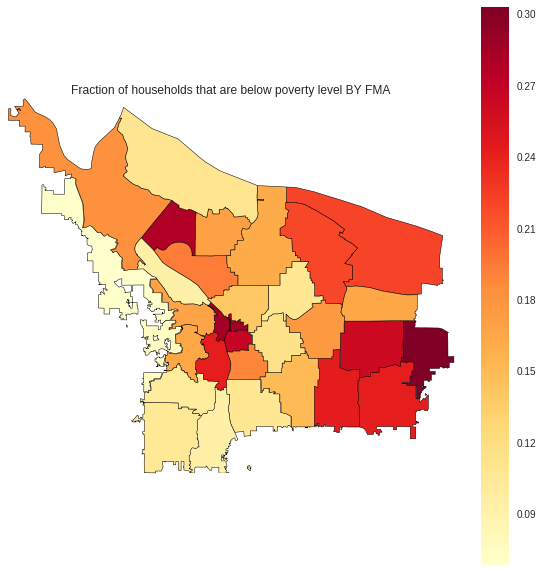

In [74]:
gplt.choropleth(df10,
                hue=df10['percent_below_pov'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlOrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households that are below poverty level BY FMA")

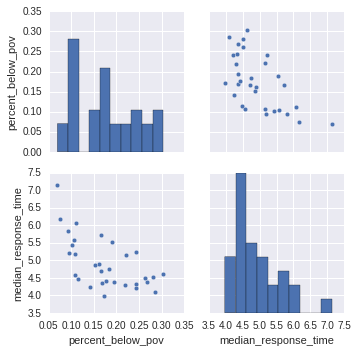

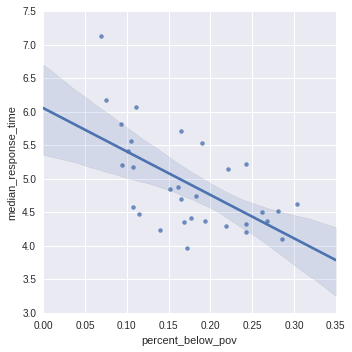

In [75]:
# generate pairplot/scatterplot of fraction below poverty level and response time

df10.fma = df10.fma.astype(int)
merged = fma_med_response.merge(df10, on='fma')
sns.pairplot(merged, vars = ['percent_below_pov','median_response_time'])
sns.lmplot('percent_below_pov', 'median_response_time',
           data=merged,
           fit_reg=True)

In [76]:
# explore households with member 65+ years by FMA

QUERY11='''SELECT f.fma,
  round(sum(c.totals*f.overlap_cbg)) AS total,
  round(sum(c.oneplus_people_65plus*f.overlap_cbg)) AS member_65plus,
  ((sum(c.oneplus_people_65plus*f.overlap_cbg))/(sum(c.totals*f.overlap_cbg)))
       AS percent_member_65plus,   
  s.geom   
FROM fmac_proportion f INNER JOIN census_households_65plus c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_member_65plus DESC
'''


In [77]:
df11 = gpd_query(QUERY11)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.totals*f.overlap_cbg)) AS total,
  round(sum(c.oneplus_people_65plus*f.overlap_cbg)) AS member_65plus,
  ((sum(c.oneplus_people_65plus*f.overlap_cbg))/(sum(c.totals*f.overlap_cbg)))
       AS percent_member_65plus,   
  s.geom   
FROM fmac_proportion f INNER JOIN census_households_65plus c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_member_65plus DESC


created geopandas dataframe!


In [78]:
df11[df11.columns[:-1]]

,fma,total,member_65plus,percent_member_65plus
0,30,8969.0,3325.0,0.370708
1,17,1947.0,650.0,0.333700
2,16,1735.0,549.0,0.316685
3,2,5894.0,1698.0,0.288154
4,20,8474.0,2074.0,0.244761
5,10,4629.0,1119.0,0.241722
6,31,10189.0,2393.0,0.234895
7,5,7641.0,1764.0,0.230821
8,7,14879.0,3408.0,0.229038
9,29,7960.0,1802.0,0.226320


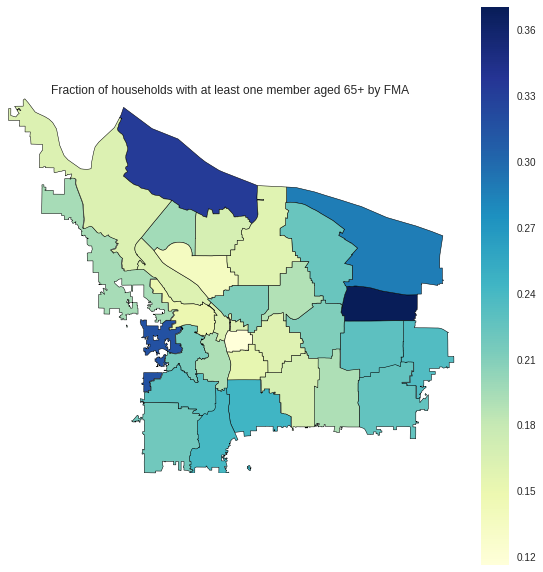

In [79]:
gplt.choropleth(df11,
                hue=df11['percent_member_65plus'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlGnBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households with at least one member aged 65+ by FMA")

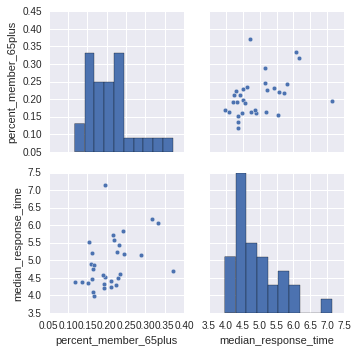

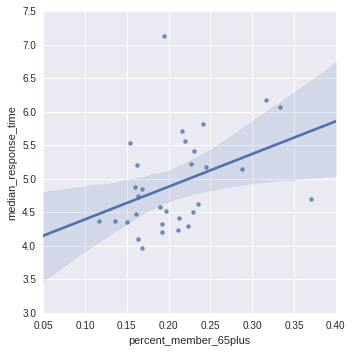

In [80]:
# generate pairplot/scatterplot of fraction of hh with member 65+ and response time

df11.fma = df11.fma.astype(int)
merged = fma_med_response.merge(df11, on='fma')
sns.pairplot(merged, vars = ['percent_member_65plus','median_response_time'])
sns.lmplot('percent_member_65plus', 'median_response_time',
           data=merged,
           fit_reg=True)

In [81]:
# explore geographical mobility by FMA

QUERY12='''SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.Same_house_one_yr*f.overlap_cbg)) AS same_house,
  round(sum(c.diff_house_US_one_yr*f.overlap_cbg)) AS diff_house_same_metro,
  round((sum(c.diff_house_US_one_yr*f.overlap_cbg))-(sum(c.diff_house_US_one_yr_Same_metro*f.overlap_cbg)))
       AS diff_area_total,
  (((sum(c.diff_house_US_one_yr*f.overlap_cbg))-(sum(c.diff_house_US_one_yr_Same_metro*f.overlap_cbg)))/
       (sum(c.total*f.overlap_cbg))) AS percent_diff_area,
  round(sum(c.Abroad_one_yr*f.overlap_cbg)) AS diff_country,
  ((sum(c.Abroad_one_yr*f.overlap_cbg))/(sum(c.total*f.overlap_cbg))) AS percent_diff_country,
  s.geom
FROM fmac_proportion f INNER JOIN census_geographical_mobility c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_diff_area DESC
'''



In [82]:
df12 = gpd_query(QUERY12)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total*f.overlap_cbg)) AS total,
  round(sum(c.Same_house_one_yr*f.overlap_cbg)) AS same_house,
  round(sum(c.diff_house_US_one_yr*f.overlap_cbg)) AS diff_house_same_metro,
  round((sum(c.diff_house_US_one_yr*f.overlap_cbg))-(sum(c.diff_house_US_one_yr_Same_metro*f.overlap_cbg)))
       AS diff_area_total,
  (((sum(c.diff_house_US_one_yr*f.overlap_cbg))-(sum(c.diff_house_US_one_yr_Same_metro*f.overlap_cbg)))/
       (sum(c.total*f.overlap_cbg))) AS percent_diff_area,
  round(sum(c.Abroad_one_yr*f.overlap_cbg)) AS diff_country,
  ((sum(c.Abroad_one_yr*f.overlap_cbg))/(sum(c.total*f.overlap_cbg))) AS percent_diff_country,
  s.geom
FROM fmac_proportion f INNER JOIN census_geographical_mobility c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_diff_area DESC


created geopandas dataframe!


In [83]:
df12[df12.columns[:-1]]

,fma,total,same_house,diff_house_same_metro,diff_area_total,percent_diff_area,diff_country,percent_diff_country
0,4,17459.0,9551.0,7395.0,3115.0,0.178416,512.0,0.029348
1,21,4609.0,3039.0,1529.0,574.0,0.124469,41.0,0.008895
2,3,21980.0,14865.0,6547.0,2491.0,0.113334,568.0,0.025846
3,1,7287.0,4458.0,2799.0,683.0,0.093712,30.0,0.004135
4,23,11645.0,8789.0,2743.0,854.0,0.073326,114.0,0.009786
5,10,10915.0,8709.0,1970.0,785.0,0.071941,236.0,0.021589
6,24,16493.0,12342.0,4005.0,1170.0,0.070950,146.0,0.008826
7,26,21635.0,16607.0,4852.0,1529.0,0.070668,177.0,0.008166
8,15,9481.0,7371.0,2032.0,631.0,0.066575,79.0,0.008306
9,9,34042.0,26851.0,6932.0,1968.0,0.057801,259.0,0.007612


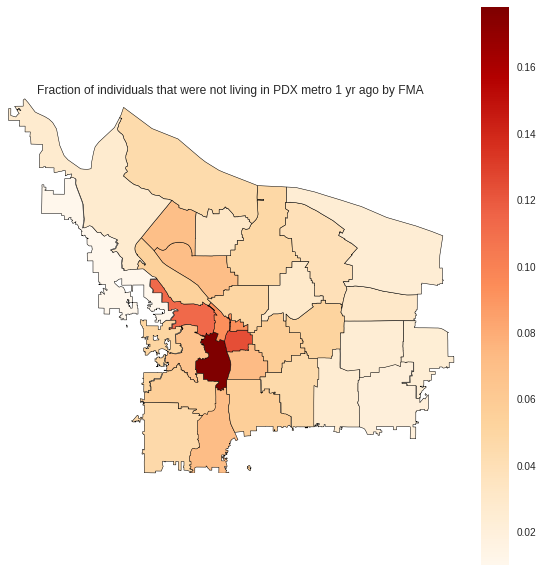

In [84]:
gplt.choropleth(df12,
                hue=df12['percent_diff_area'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))


plt.title("Fraction of individuals that were not living in PDX metro 1 yr ago by FMA")



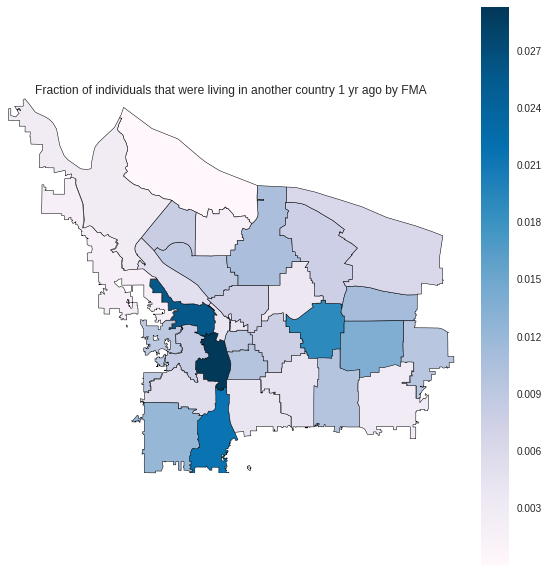

In [85]:
gplt.choropleth(df12,
                hue=df12['percent_diff_country'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='PuBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))        
        
        
plt.title("Fraction of individuals that were living in another country 1 yr ago by FMA")

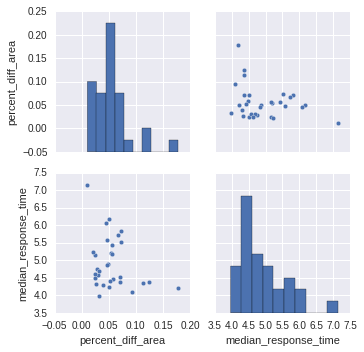

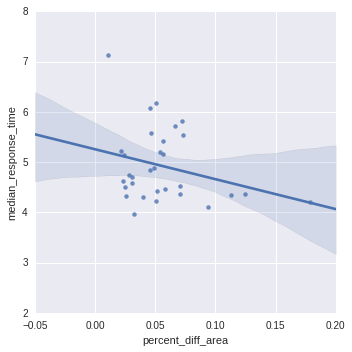

In [86]:
# generate pairplot/scatterplot of fraction of not living in same PDX metro last year and response time

df12.fma = df12.fma.astype(int)
merged = fma_med_response.merge(df12, on='fma')
sns.pairplot(merged, vars = ['percent_diff_area','median_response_time'])
sns.lmplot('percent_diff_area', 'median_response_time',
           data=merged,
           fit_reg=True)

When comparing by raw scatterplot (no outliers removed), I see no obvious relationship between FMA response time and the following demographic metrics:

  * total population
  * percent college grad or higher
  * percent of households with limited english speaking status
  * percent of individuals that are non-white
  * percent households with at least one member 65+
  * percent of individuals not living in PDX one year ago
    
Similar scatterplots show possible correlation between response time and the following demographic metrics:

  * percent owner-occupied
  * median household income
  * percent of individuals w/o health insurance
  * percent of households receiving food stamps/SNAP
  * percent of households below poverty level
    
Interestingly, there is some consistency to the metrics in this second group. They are all related to household/individual socio-economic/financial status and thus are likely correlated to one another. In this sense, it's logical that they would all show some possible relationship to response time if one of them appears to. The likeliest explanation may be that FMAs with these higher values for socio-economic markers also tend to be FMAs up in the West Hills of PDX. We have not explored this quantitatively yet, but one way to possibly explore this is to take the distance from each FMA station to the centroid of the census block of the incident. This would give some estimate of straight line distance for each incident, but would not include effects such as windy, narrow, or hilly roads.
 
Given these results, I am somewhat surprised that perccent college grad does not show stronger relationship to response time since the postive relationship between level of education and economic status are well documented. 
Note that these scatterplots are quite sparse, with only 31 points (based on the number of FMAs). If we are interesed in exploring these possible relationships further, one idea is to re-aggregate by fireblock instead of fma since that would increase the number of datapoints to compare from 31 to 578.

  
    

In [87]:
# try joining census_dfhousehold_income by census block group to fma to look at income distribution
# put this at the end of notebook since there are many distribution charts

QUERY13='''SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_124999,
  round(sum(c.total_125000_to_149999*f.overlap_fma)) AS fr_125000_to_149999,
  round(sum(c.total_150000_to_199999*f.overlap_fma)) AS fr_150000_to_199999,
  round(sum(c.total_200000_or_more*f.overlap_fma)) AS fr_200000_or_more
FROM fmac_proportion f INNER JOIN census_household_income c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY f.fma
'''

In [88]:
df13 = pquery(QUERY13)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_1

In [89]:
df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 17 columns):
fma                    31 non-null int64
less_than_10000        31 non-null float64
fr_10000_to_14999      31 non-null float64
fr_15000_to_19999      31 non-null float64
fr_20000_to_24999      31 non-null float64
fr_25000_to_29999      31 non-null float64
fr_30000_to_34999      31 non-null float64
fr_35000_to_39999      31 non-null float64
fr_40000_to_44999      31 non-null float64
fr_45000_to_49999      31 non-null float64
fr_50000_to_59999      31 non-null float64
fr_60000_to_74999      31 non-null float64
fr_75000_to_99999      31 non-null float64
fr_100000_to_124999    31 non-null float64
fr_125000_to_149999    31 non-null float64
fr_150000_to_199999    31 non-null float64
fr_200000_or_more      31 non-null float64
dtypes: float64(16), int64(1)
memory usage: 4.2 KB


In [90]:
df13

,fma,less_than_10000,fr_10000_to_14999,fr_15000_to_19999,fr_20000_to_24999,fr_25000_to_29999,fr_30000_to_34999,fr_35000_to_39999,fr_40000_to_44999,fr_45000_to_49999,fr_50000_to_59999,fr_60000_to_74999,fr_75000_to_99999,fr_100000_to_124999,fr_125000_to_149999,fr_150000_to_199999,fr_200000_or_more
0,1,181.0,108.0,52.0,73.0,48.0,29.0,33.0,38.0,12.0,53.0,71.0,84.0,58.0,19.0,34.0,92.0
1,2,25.0,18.0,12.0,6.0,18.0,21.0,21.0,62.0,28.0,80.0,104.0,135.0,66.0,28.0,43.0,17.0
2,3,74.0,43.0,30.0,35.0,34.0,32.0,36.0,37.0,18.0,67.0,74.0,128.0,109.0,57.0,68.0,184.0
3,4,106.0,36.0,33.0,23.0,49.0,52.0,30.0,33.0,28.0,43.0,76.0,120.0,83.0,54.0,67.0,85.0
4,5,37.0,21.0,25.0,20.0,28.0,31.0,25.0,23.0,18.0,34.0,50.0,88.0,65.0,63.0,63.0,81.0
5,6,20.0,6.0,13.0,16.0,8.0,20.0,6.0,19.0,17.0,70.0,46.0,71.0,54.0,59.0,48.0,76.0
6,7,87.0,67.0,73.0,60.0,52.0,56.0,46.0,37.0,43.0,68.0,82.0,81.0,39.0,25.0,8.0,11.0
7,8,41.0,21.0,49.0,19.0,62.0,37.0,22.0,17.0,30.0,94.0,89.0,113.0,70.0,28.0,30.0,9.0
8,9,31.0,18.0,22.0,24.0,25.0,26.0,24.0,20.0,17.0,39.0,43.0,74.0,52.0,34.0,35.0,51.0
9,10,28.0,9.0,18.0,15.0,15.0,18.0,24.0,18.0,20.0,37.0,67.0,98.0,78.0,61.0,82.0,137.0


/home/vagrant/miniconda3/envs/ipykernel_py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


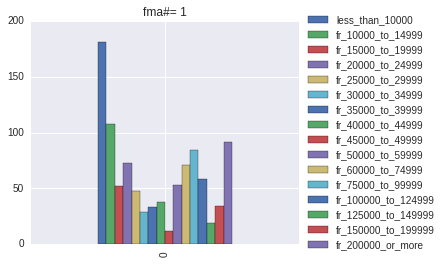

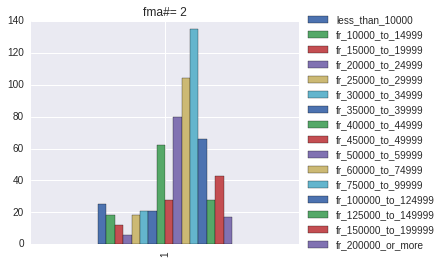

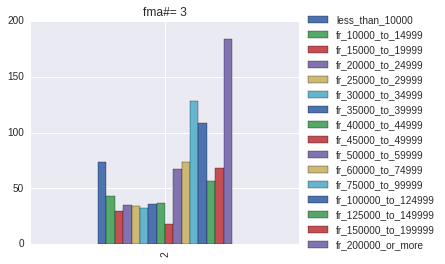

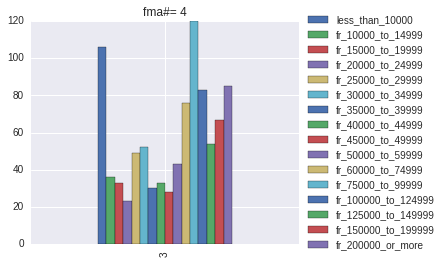

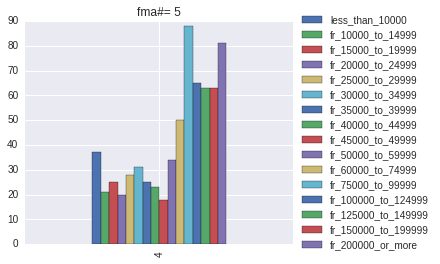

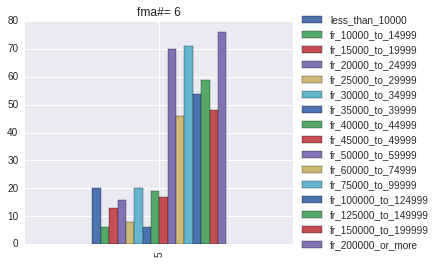

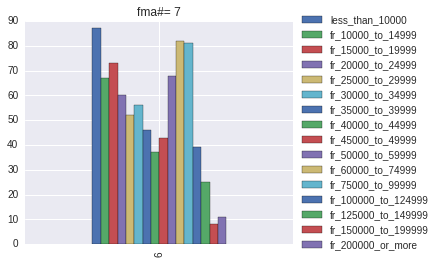

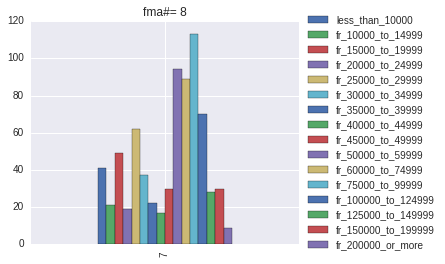

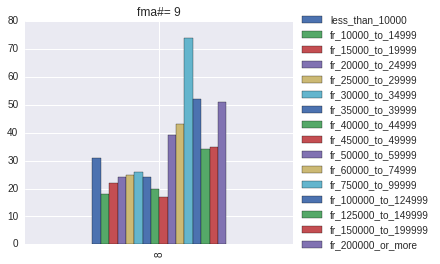

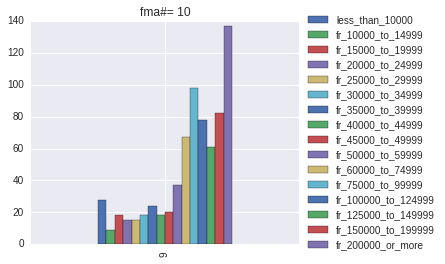

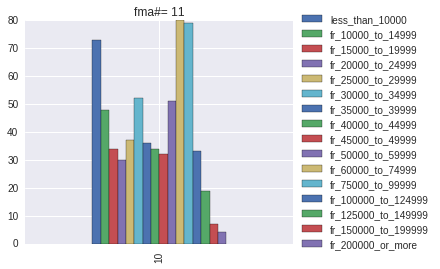

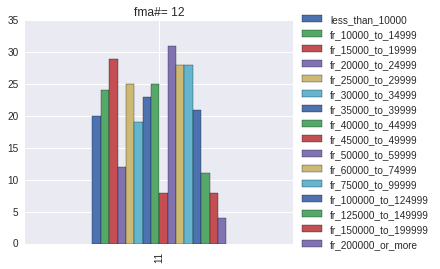

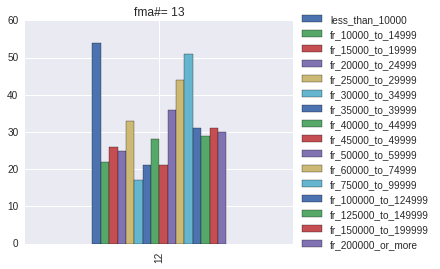

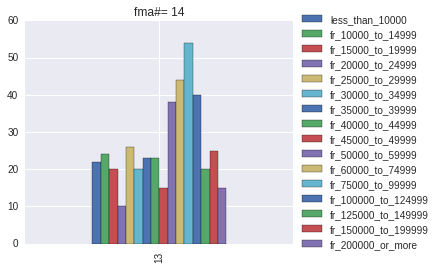

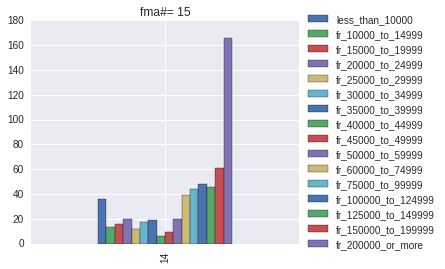

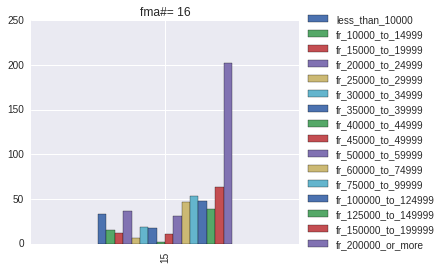

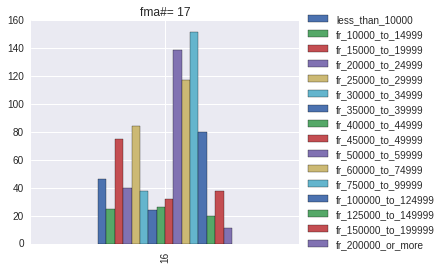

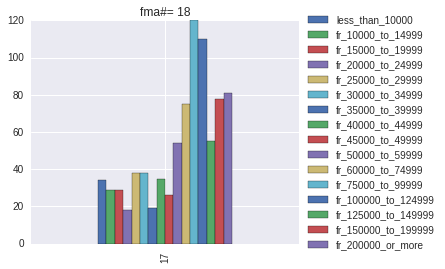

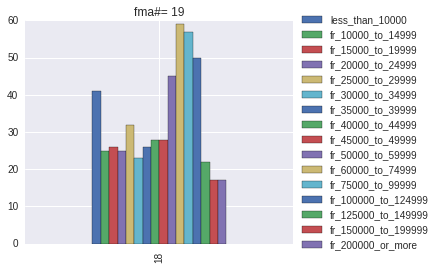

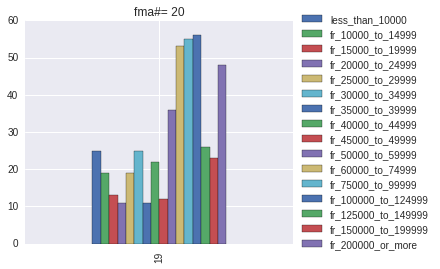

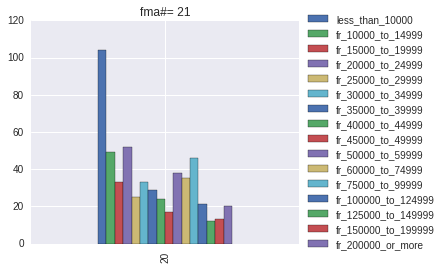

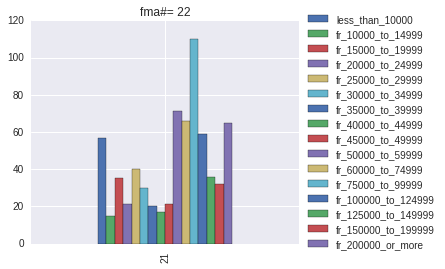

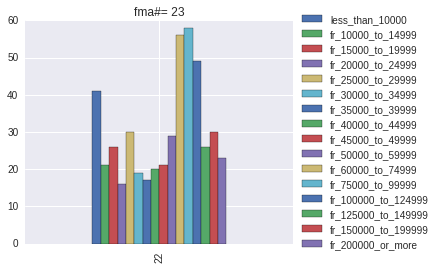

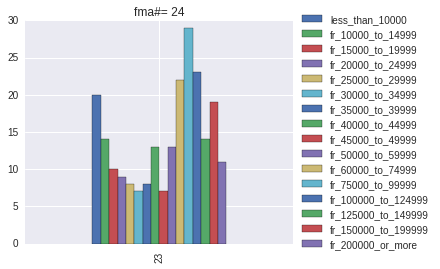

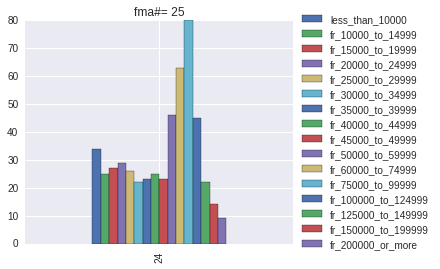

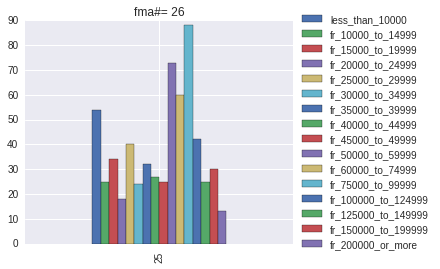

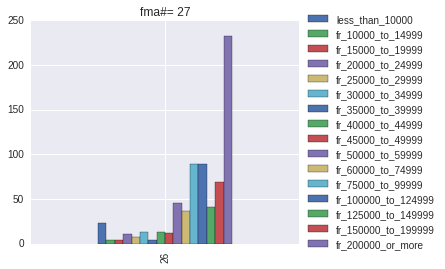

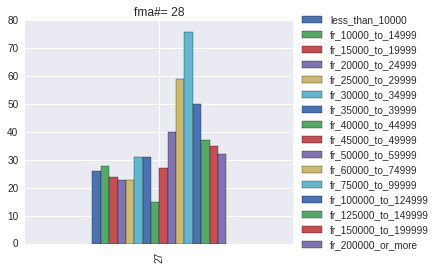

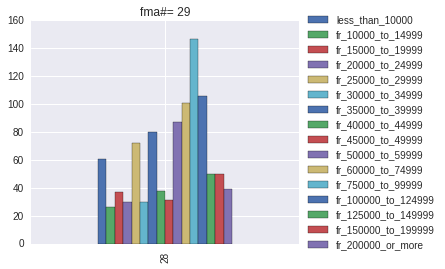

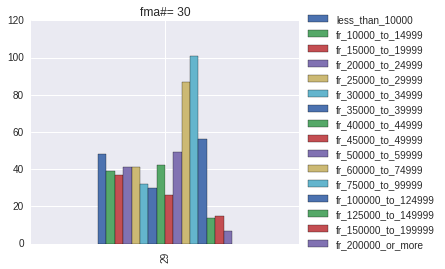

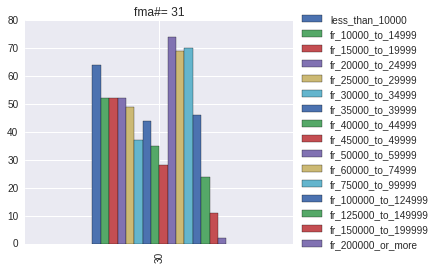

In [91]:
for i in df13['fma']:
    df13.loc[df13['fma'] == i,'less_than_10000':].plot(kind = 'bar',title = "fma#= "+str(i))
    # Shrink current axis by 20%
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
            